# Box模糊

In [3]:
from scipy import signal
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [27]:
src = cv2.imread('../../datas/building_2.jpg')
gray = cv2.imread('../../datas/building_2.jpg',0)
rgb = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)

In [8]:
def boxblur(image, blur_mask, iterations=3):
    ''' boxblur using numpy '''

    blur_mask = blur_mask.astype(np.float)
    self_blur_mask = (9 - (blur_mask * 8)) / 9.0
    other_blur_mask = blur_mask / 9.0

    red = image[...,0].astype(np.float)
    green = image[...,1].astype(np.float)
    blue = image[...,2].astype(np.float)

    blur_weights = np.dstack((other_blur_mask, other_blur_mask, other_blur_mask,
                       other_blur_mask, self_blur_mask, other_blur_mask,
                       other_blur_mask, other_blur_mask, other_blur_mask))

    for i in range(iterations):
        red_padded = np.pad(red, 1, mode='edge')
        green_padded = np.pad(green, 1, mode='edge')
        blue_padded = np.pad(blue, 1, mode='edge')

        red_stacked = np.dstack((red_padded[:-2,  :-2], red_padded[:-2,  1:-1], red_padded[:-2,  2:],
                                 red_padded[1:-1, :-2], red_padded[1:-1, 1:-1], red_padded[1:-1, 2:],
                                 red_padded[2:,   :-2], red_padded[2:,   1:-1], red_padded[2:,   2:]))
        green_stacked = np.dstack((green_padded[:-2,  :-2], green_padded[:-2,  1:-1], green_padded[:-2,  2:],
                                   green_padded[1:-1, :-2], green_padded[1:-1, 1:-1], green_padded[1:-1, 2:],
                                   green_padded[2:,   :-2], green_padded[2:,   1:-1], green_padded[2:,   2:]))
        blue_stacked = np.dstack((blue_padded[:-2,  :-2], blue_padded[:-2,  1:-1], blue_padded[:-2,  2:],
                                  blue_padded[1:-1, :-2], blue_padded[1:-1, 1:-1], blue_padded[1:-1, 2:],
                                  blue_padded[2:,   :-2], blue_padded[2:,   1:-1], blue_padded[2:,   2:]))

        red = np.average(red_stacked, axis=2, weights=blur_weights).astype(np.uint8)
        green = np.average(green_stacked, axis=2, weights=blur_weights).astype(np.uint8)
        blue = np.average(blue_stacked, axis=2, weights=blur_weights).astype(np.uint8)

    image = np.dstack((red, green, blue))
    return image

In [9]:
# generates horizontal blur mask using focus middle, focus radius, and image height,
# and stores the blur mask in the blur_mask parameter (np.array)
def generate_horizontal_blur_mask(blur_mask, middle_in_focus, in_focus_radius, height):
    # Calculate blur amount for each pixel based on middle_in_focus and in_focus_radius
    # get vector of all y values
    y_v = np.arange(middle_in_focus - in_focus_radius, middle_in_focus + in_focus_radius + 1)

    # Loop over y first so we can calculate the blur amount
    # fade out 20% to blurry so that there is not an abrupt transition
    no_blur_region = .8 * in_focus_radius
    no_blur_region_v = np.full(y_v.shape, .8 * in_focus_radius)

    # The blur amount depends on the y-value of the pixel
    # Calculate distance to center of focus region
    distance_to_m_v = np.absolute(y_v - middle_in_focus)

    # determine which y values are in the transition region
    in_transition = np.greater(distance_to_m_v, no_blur_region_v)

    # calculate the blur amount for each y assuming it is in transition
    in_transition_blur_amounts = (1.0 / (in_focus_radius - no_blur_region)) * (distance_to_m_v - no_blur_region)
    # filter out y values not in the transition region
    filtered_in_transition_blur_amounts = in_transition_blur_amounts[in_transition]
    in_transition_blur_amounts_matrix = np.tile(filtered_in_transition_blur_amounts, (blur_mask.shape[1],1)).T
    # set blur amounts to zero
    y_blur_amounts = np.zeros((y_v.shape[0],blur_mask.shape[1]))
    # set transition region y values to blur amount
    y_blur_amounts[in_transition] = in_transition_blur_amounts_matrix
    #set blur mask
    blur_mask[y_v] = y_blur_amounts

In [11]:
 #Generates a circular horizontal blur mask using the x and y coordinates of the focus middle,
# focus radius, and image height, and stores the blur mask in the blur_mask parameter (np.array)
def generate_circular_blur_mask(blur_mask, middle_in_focus_x, middle_in_focus_y, in_focus_radius, width, height):
    # Calculate blur amount for each pixel based on middle_in_focus and in_focus_radius

    # Fade out 20% to blurry so that there is not an abrupt transition
    no_blur_region = .8 * in_focus_radius
    # Set blur amount (no blur) for center of in-focus region
    #blur_mask[middle_in_focus_y, middle_in_focus_x] = 0.0

    # Calculate all x,y coords
    x_coords = np.arange(middle_in_focus_x - in_focus_radius, middle_in_focus_x + in_focus_radius + 1)
    y_coords = np.arange(middle_in_focus_y - in_focus_radius, middle_in_focus_y + in_focus_radius + 1)
    xy_list = cartesian([x_coords, y_coords])

    # Check if coordinates are in image bounds
    size_arr = np.full(xy_list.shape,(width,height))
    greater_than_zero = np.greater(xy_list,np.zeros(xy_list.shape))
    greater_than_zero = greater_than_zero.T
    greater_than_zero = np.logical_and(greater_than_zero[0],greater_than_zero[1]).T
    less_than_upper_bound = np.less(xy_list, size_arr)
    less_than_upper_bound = less_than_upper_bound.T
    less_than_upper_bound = np.logical_and(less_than_upper_bound[0],less_than_upper_bound[1]).T
    in_bounds_coords = np.logical_and(greater_than_zero,less_than_upper_bound)

    # Drop out of bounds coordinates
    xy_list = xy_list[in_bounds_coords]

    #separate x's and y's into separate arrays
    xy_list = xy_list.T

    # Loop over x and y first so we can calculate the blur amount
    v_ciruclar_blur_mask_helper = np.vectorize(ciruclar_blur_mask_helper)
    xy_blur_amounts = v_ciruclar_blur_mask_helper(xy_list[0],xy_list[1], middle_in_focus_x, middle_in_focus_y, in_focus_radius, no_blur_region)
    blur_mask[xy_list[1],xy_list[0]] = xy_blur_amounts
    

In [12]:
def ciruclar_blur_mask_helper(x, y, middle_in_focus_x, middle_in_focus_y, in_focus_radius, no_blur_region):
    # a function that is vectorized in generate_circular_blur_mask
    # takes vectors x,y as parameters and returns a vector of blur amounts
    # one for each x,y pair
    x_distance_to_m = np.absolute(x - middle_in_focus_x)
    y_distance_to_m = np.absolute(y - middle_in_focus_y)
    distance_to_m = (x_distance_to_m ** 2 + y_distance_to_m ** 2) ** 0.5
    blur_amount = 1.0
    # Note: Not all values we iterate over are within the focus region, so we must check
    if distance_to_m < no_blur_region:
        # No blur
        blur_amount = 0.0
    # Check if we should fade to blurry so that there is not an abrupt transition
    elif distance_to_m < in_focus_radius:
        blur_amount = (1.0 / (in_focus_radius - no_blur_region)) * (distance_to_m - no_blur_region)

    return blur_amount

In [19]:
def cartesian(arrays, out=None):
    # This code was adapted from
    # http://stackoverflow.com/questions/1208118/using-numpy-to-build-an-array-of-all-combinations-of-two-arrays
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """
    dtype = arrays[0].dtype
    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n // arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [28]:
rows,cols = rgb.shape[0],rgb.shape[1]
blur_mask = np.zeros((rows,cols),dtype=np.float32)
generate_circular_blur_mask(blur_mask,cols // 2,rows // 2,rows // 2,cols,rows)

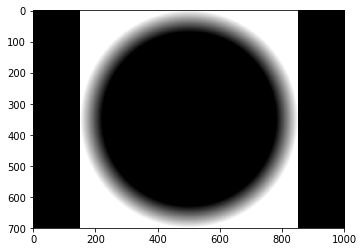

In [29]:
plt.imshow(blur_mask,'gray')

In [30]:
dst = boxblur(rgb,blur_mask)

Text(0.5,1,'DST')

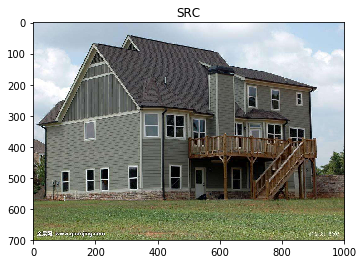

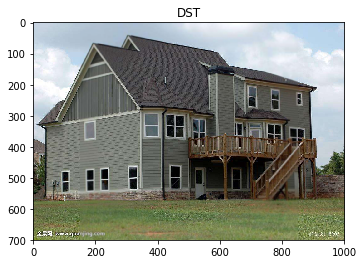

In [32]:
plt.figure()
plt.imshow(rgb)
plt.title('SRC')
plt.figure()
plt.imshow(dst)
plt.title('DST')

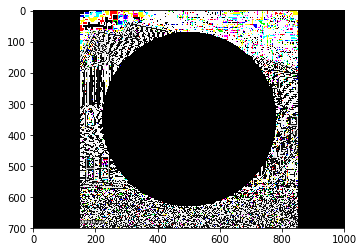

In [33]:
diff = dst - rgb
diff[diff < 0] = 0
plt.imshow(diff)